In [4]:
import tensorflow as tf
import cv2
import sys
import numpy as np
#from tensorflow.keras.applications.resnet50 import preprocess_input
from efficientnet.tfkeras import EfficientNetB0, preprocess_input
import pandas as pd
import os
from PIL import Image
import glob
import xml.etree.ElementTree as ET
from xml.dom import minidom
import matplotlib.pyplot as plt
#import efficientnet.tfkeras
from tensorflow.keras.models import load_model

ModuleNotFoundError: No module named 'efficientnet'

In [29]:
tf.test.is_gpu_available()

True

In [144]:
def crop_image(image, boxes, save_path, resize=None):
        #seed_image = Image.open(os.listdir('./imgs')[0])
        seed_image = Image.open(image)
        images = list(map(lambda b : seed_image.crop(b), boxes))
        if str(type(resize)) == "<class 'tuple'>":
            images = list(map(lambda i : i.resize(resize), images))
        num = 0
        
        for img in images:
            num = num + 1
            img.save('{}/{}.jpg'.format(save_path, num))
            

def get_boxes(label_path):
    label_path = label_path
    xml_list = os.listdir(label_path)

    boxes_1 = {}
    cnt = 0
    for xml_file in sorted(xml_list):
        if xml_file =='.DS_Store':
            pass
        else:
                #try:
            xml_path = os.path.join(label_path,xml_file)

            root_1 = minidom.parse(xml_path)
            bnd_1 = root_1.getElementsByTagName('bndbox')

            result = []
            for i in range(len(bnd_1)):
                xmin = int(bnd_1[i].childNodes[1].childNodes[0].nodeValue)
                ymin = int(bnd_1[i].childNodes[3].childNodes[0].nodeValue)
                xmax = int(bnd_1[i].childNodes[5].childNodes[0].nodeValue)
                ymax = int(bnd_1[i].childNodes[7].childNodes[0].nodeValue)
                result.append((xmin,ymin,xmax,ymax))

            boxes_1[str(cnt)] = result
            cnt += 1
    
    return boxes_1

def infer(cropped_image_list, model_name, class_file):
    result = []
    for image in cropped_image_list:
        file_info = image.split('/')[-2]

        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image = cv2.resize(image, (IMG_RESIZE, IMG_RESIZE))

        image = np.expand_dims(image, axis=0)
        image = preprocess_input(image)
        predictions = model_name.predict(image, steps=1)
        
        #index = np.argmax(predictions[0])
        #name = str(class_file[index])
        #score = str(predictions[0][index])
        #print(name, score)
        score = np.argmax(predictions[0])
 
        
        result.append(class_file[score])
        
    return result


In [11]:
#### 
df = pd.read_csv('./labels_1.txt', sep = ' ', index_col=False, header=None)
CLASS_NAMES = df[0].tolist()
CLASS_NAMES = sorted(CLASS_NAMES)

df = pd.read_csv('./labels_binary.txt', sep = ' ', index_col=False, header=None)
EM_CLASS_NAMES = df[0].tolist()
EM_CLASS_NAMES = sorted(EM_CLASS_NAMES)

print(CLASS_NAMES)
print(len(CLASS_NAMES))
print(EM_CLASS_NAMES)

#model = tf.keras.models.load_model('./model/beverage.h5')
empty_model = tf.keras.models.load_model('./1.model/efn_binary_empty.h5')
main_model = tf.keras.models.load_model('./1.model/em24.h5')


['2%_can', '2%_peach_pet', 'aloe_pet', 'bongbong_can', 'coca_can', 'coca_pet', 'dailyC_pet', 'demisoda_can', 'fantaorange_pet', 'fantapine_pet', 'galbae_can', 'galbae_pet', 'hwal_pet', 'jeju_pet', 'lemonade_pet', 'mango_can', 'mccol_pet', 'milkis_can', 'milkis_pet', 'mogumogu_pet', 'morning_pet', 'oranC_can', 'peach_can', 'pepsi_can', 'pepsi_pet', 'pocari_can', 'power_can', 'redbull_can', 'sol_can', 'sprite_can', 'sprite_pet', 'tejava_can', 'vilak_pet', 'vita500_pet', 'welchs_can']
35
['empty', 'product']


In [14]:
img_num = 0

em_boxes = get_boxes('./4.xml_empty')['0']
main_boxes = get_boxes('./4.xml')['0']


crop_image('./2.seed_img/' + os.listdir('./2.seed_img')[img_num], 
           em_boxes, 
           './3.empty_imgs',
           (224,224))

crop_image('./2.seed_img/' + os.listdir('./2.seed_img')[img_num], 
           main_boxes, 
           './3.cls_imgs',
           (224,224))

empty_img_list = sorted(glob.glob('./3.empty_imgs/*'))
main_img_list = sorted(glob.glob('./3.cls_imgs/*'))


empty_result = infer(cropped_image_list = empty_img_list, 
                     model_name = empty_model, 
                     class_file=EM_CLASS_NAMES)

main_result = infer(cropped_image_list = main_img_list, 
                    model_name = main_model, 
                    class_file=CLASS_NAMES)

final_result = [i if i == 'empty' else j for i,j in zip(empty_result, main_result)]
pd.DataFrame(final_result).T

0      1          2            3            4      5  \
0  mogumogu_pet  empty  pepsi_can  morning_pet  morning_pet  empty   

             6  
0  morning_pet

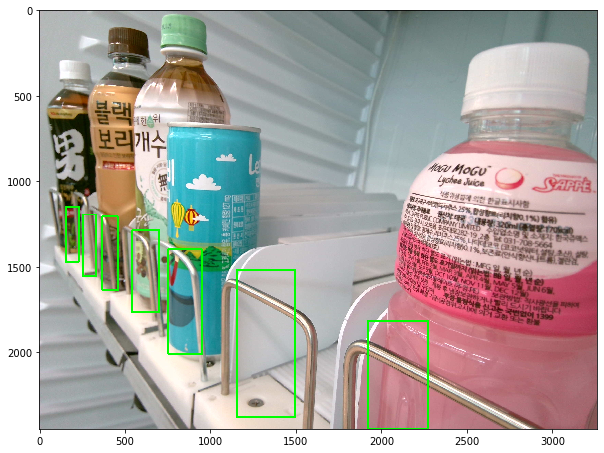

In [15]:

im = cv2.imread('./2.seed_img/' + os.listdir('./2.seed_img')[img_num])
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

for i in range(7):
    cv2.rectangle(im, (em_boxes[i][0],em_boxes[i][1]),(em_boxes[i][2],em_boxes[i][3]), (0,255,0),10)
#print(final_result)
#cv2.rectangle(im, main_boxes[1], (255,0,0),2)
plt.figure(figsize=(10, 10))
plt.imshow(im)

In [15]:
df = pd.read_csv('./5.labels/labels_binary.txt', sep = ' ', index_col=False, header=None)
EM_CLASS_NAMES = df[0].tolist()
EM_CLASS_NAMES = sorted(EM_CLASS_NAMES)


#model = tf.keras.models.load_model('./model/beverage.h5')
empty_model1 = tf.keras.models.load_model('./1.model/total_empty.h5')
empty_model2 = tf.keras.models.load_model('./1.model/empty_final.h5')



In [26]:
img_num = 0

em_boxes = get_boxes('./4.xml_empty')['0']

crop_image('./2.seed_img/' + os.listdir('./2.seed_img')[img_num], 
           em_boxes, 
           './3.empty_imgs',
           (224,224))


empty_img_list = sorted(glob.glob('./3.empty_imgs/*'))


empty_result1 = infer(cropped_image_list = empty_img_list, 
                     model_name = empty_model1, 
                     class_file=EM_CLASS_NAMES)


empty_result2 = infer(cropped_image_list = empty_img_list, 
                     model_name = empty_model2, 
                     class_file=EM_CLASS_NAMES)
#final_result = [i if i == 'empty' else j for i,j in zip(empty_result, main_result)]
pd.DataFrame(empty_result1).T

0      1      2      3      4      5      6        7
0  empty  empty  empty  empty  empty  empty  empty  product

In [27]:
pd.DataFrame(empty_result2).T

0      1      2      3      4        5        6        7
0  empty  empty  empty  empty  empty  product  product  product

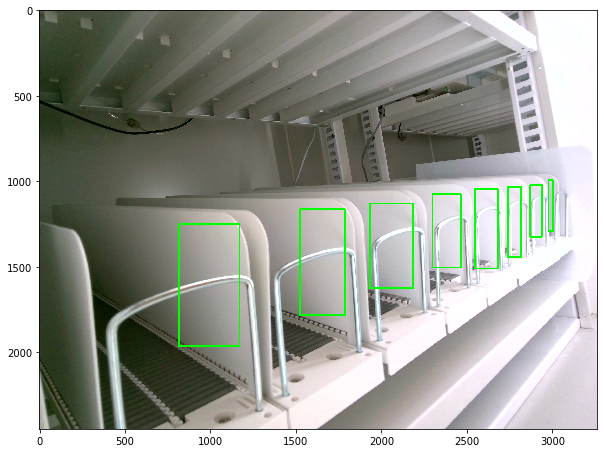

In [25]:
im = cv2.imread('./2.seed_img/' + os.listdir('./2.seed_img')[img_num])
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

for i in range(8):
    cv2.rectangle(im, (em_boxes[i][0],em_boxes[i][1]),(em_boxes[i][2],em_boxes[i][3]), (0,255,0),10)
#print(final_result)
#cv2.rectangle(im, main_boxes[1], (255,0,0),2)
plt.figure(figsize=(10, 10))
plt.imshow(im)

In [134]:
df = pd.read_csv('./5.labels/labels_beverage_final.txt', sep = ' ', index_col=False, header=None)
#df = pd.read_csv('./5.labels/labels_sn_pd.txt', sep = ' ', index_col=False, header=None)

CLASS_NAMES = df[0].tolist()
CLASS_NAMES = sorted(CLASS_NAMES)


In [204]:
df = pd.read_csv('./5.labels/labels_beverage_final.txt', sep = ' ', index_col=False, header=None)
#df = pd.read_csv('./5.labels/labels_sn_pd.txt', sep = ' ', index_col=False, header=None)
CLASS_NAMES = df[0].tolist()
CLASS_NAMES = sorted(CLASS_NAMES)

#df = pd.read_csv('./labels_binary.txt', sep = ' ', index_col=False, header=None)
#EM_CLASS_NAMES = df[0].tolist()
#EM_CLASS_NAMES = sorted(EM_CLASS_NAMES)

#print(CLASS_NAMES)
#print(len(CLASS_NAMES))
#print(EM_CLASS_NAMES)

#model = tf.keras.models.load_model('./model/beverage.h5')
empty_model = tf.keras.models.load_model('./1.model/total_empty.h5')
main_model = tf.keras.models.load_model('./1.model/walkin_beverage_final.h5')
#main_model1 = tf.keras.models.load_model('./1.model/walkin_sn_pd_final.h5')

In [130]:
img_num = 0

em_boxes = get_boxes('./4.xml_empty')['0']
main_boxes = get_boxes('./4.xml')['0']
#main_boxes = get_boxes('./4.xml')[str(img_num)]

crop_image('./2.seed_img/' + os.listdir('./2.seed_img')[img_num], 
           em_boxes, 
           './3.empty_imgs',
           (224,224))

crop_image('./2.seed_img/' + os.listdir('./2.seed_img')[img_num], 
           main_boxes, 
           './3.cls_imgs',
           (224,224))

empty_img_list = sorted(glob.glob('./3.empty_imgs/*'))
main_img_list = sorted(glob.glob('./3.cls_imgs/*'))


empty_result = infer(cropped_image_list = empty_img_list, 
                     model_name = empty_model, 
                     class_file=EM_CLASS_NAMES)

main_result = infer(cropped_image_list = main_img_list, 
                    model_name = main_model, 
                    class_file=CLASS_NAMES)

final_result = [i if i == 'empty' else j for i,j in zip(empty_result, main_result)]
pd.DataFrame(main_result).T

1
1
1
1
1
1
1
1
103
104
0
1
5
27
22
21


0                  1               2                3  \
0  vita500_pet  vita500_royal_pet  G_original_pet  G_sparkling_pet   

              4            5              6                   7  
0  bacchusF_pet  dawn808_can  condition_pet  condition_lady_pet

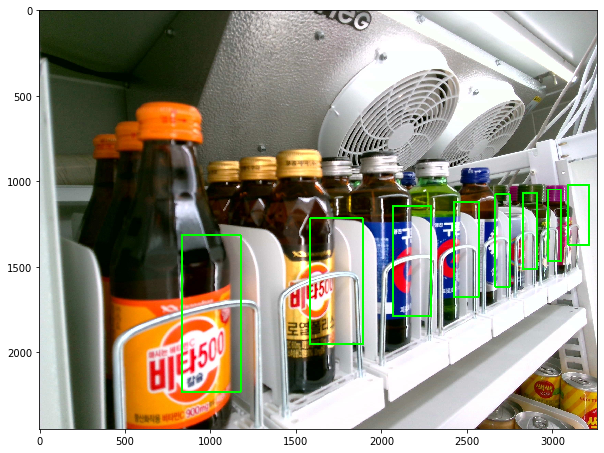

In [131]:
im = cv2.imread('./2.seed_img/' + os.listdir('./2.seed_img')[img_num])
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

for i in range(8):
    cv2.rectangle(im, (em_boxes[i][0],em_boxes[i][1]),(em_boxes[i][2],em_boxes[i][3]), (0,255,0),10)
#print(final_result)
#cv2.rectangle(im, main_boxes[1], (255,0,0),2)
plt.figure(figsize=(10, 10))
plt.imshow(im)

In [141]:
img_num = 0

em_boxes = get_boxes('./4.xml_empty')['0']
main_boxes = get_boxes('./4.xml')['0']
#main_boxes = get_boxes('./4.xml')[str(img_num)]

crop_image('./2.seed_img/' + os.listdir('./2.seed_img')[img_num], 
           em_boxes, 
           './3.empty_imgs',
           (224,224))

crop_image('./2.seed_img/' + os.listdir('./2.seed_img')[img_num], 
           main_boxes, 
           './3.cls_imgs',
           (224,224))

empty_img_list = sorted(glob.glob('./3.empty_imgs/*'))
main_img_list = sorted(glob.glob('./3.cls_imgs/*'))


empty_result = infer(cropped_image_list = empty_img_list, 
                     model_name = empty_model, 
                     class_file=EM_CLASS_NAMES)

main_result = infer(cropped_image_list = main_img_list, 
                    model_name = main_model1, 
                    class_file=CLASS_NAMES)

final_result = [i if i == 'empty' else j for i,j in zip(empty_result, main_result)]
pd.DataFrame(main_result).T

1
1
0
0
1
1
1
1
88
20
77
54
77
64
70
33


0     1      2         3      4       5       6  \
0  women_noline_hempanty  codi  squid  minioreo  squid  pepero  richam   

             7  
0  hello_kitty

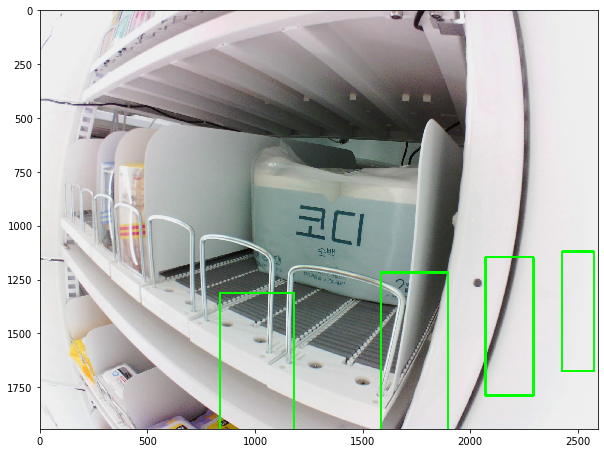

In [142]:
im = cv2.imread('./2.seed_img/' + os.listdir('./2.seed_img')[img_num])
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

for i in range(8):
    cv2.rectangle(im, (em_boxes[i][0],em_boxes[i][1]),(em_boxes[i][2],em_boxes[i][3]), (0,255,0),10)
#print(final_result)
#cv2.rectangle(im, main_boxes[1], (255,0,0),2)
plt.figure(figsize=(10, 10))
plt.imshow(im)

## 독립형

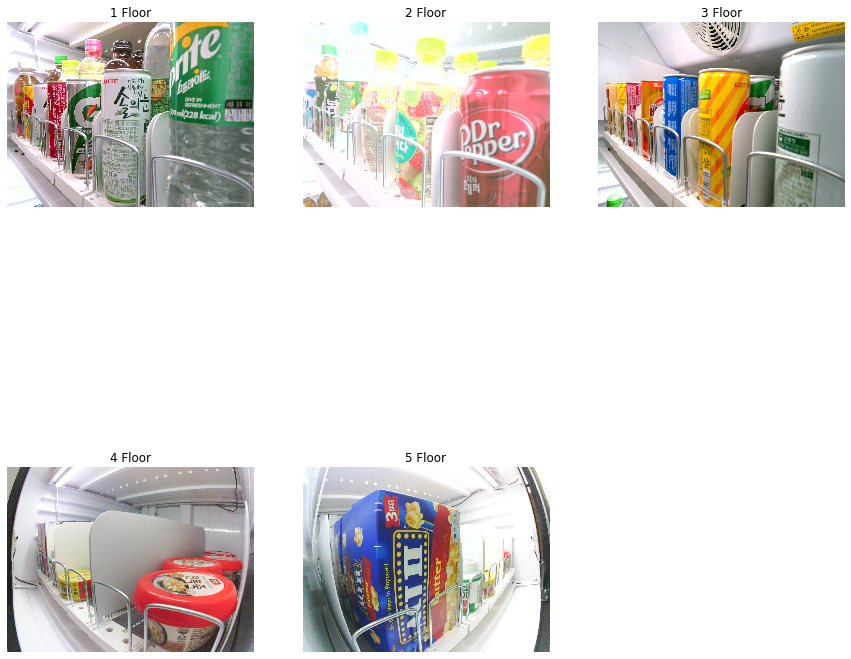

In [143]:
from io import BytesIO
from PIL import Image
import cv2
import redis
import matplotlib.pyplot as plt
import numpy as np
import imutils

r2 = redis.Redis(host='125.132.250.228', port=7379, db=2)

img_list = []
for i in range(1,4):
    img = r2.get('00999_s_00002_cam{}'.format(i))
    #buf = BytesIO(img)
    #image = Image.open(buf)
    #b, g, r = cv2.split(np.array(image))
    #image = cv2.merge((b,g,r))
    encoded_img = np.frombuffer(img, dtype = np.uint8)
    image = cv2.imdecode(encoded_img, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

   # image = imutils.rotate(image, 0)
    img_list.append(image)

for i in range(1,3):
    #img = r2.get('06346_w_00002_cam{}'.format(i))
    img = r2.get('00999_s_00002_cam0-{}'.format(i))
    #buf = BytesIO(img)
    #image = Image.open(buf)
    #b, g, r = cv2.split(np.array(image))
    #image = cv2.merge((b,g,r))
    encoded_img = np.frombuffer(img, dtype = np.uint8)
    image = cv2.imdecode(encoded_img, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = imutils.rotate(image, 0)
    img_list.append(image)
    
fig = plt.figure(2,(15,15)) # rows*cols 행렬의 i번째 subplot 생성
rows = 2
cols = 3
i = 1

for filename in img_list:
    #img = cv2.imread(filename)
    ax = fig.add_subplot(rows, cols, i)
    ax.set_title('{} Floor'.format(i))
    ax.imshow(cv2.cvtColor(filename, cv2.COLOR_BGR2RGB))
    ax.axis("off")
    
    i += 1
plt.show()

## 워크인

### 전체이미지 확인

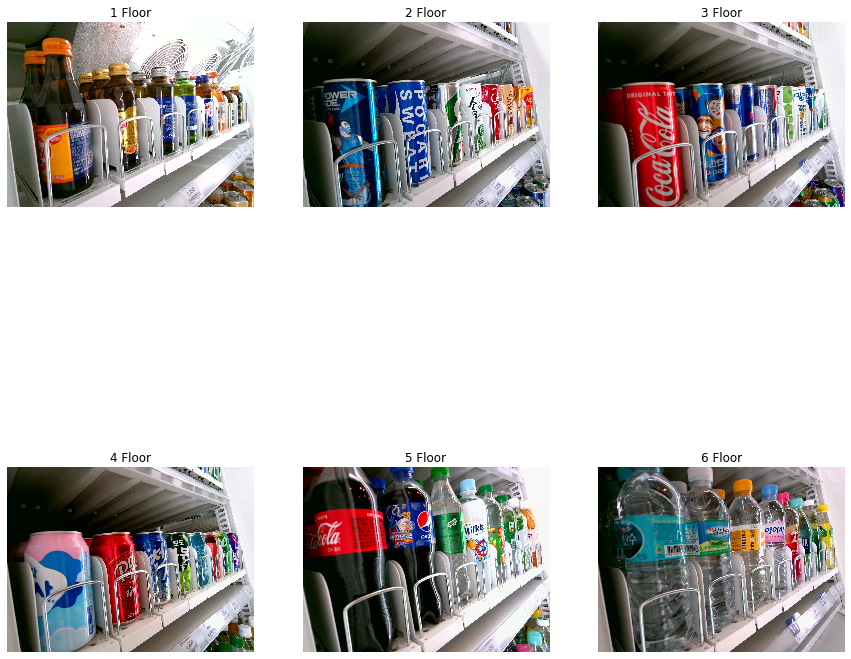

In [1]:
from io import BytesIO
#from PIL import Image
import cv2
import redis
import matplotlib.pyplot as plt
import numpy as np
import imutils
from keys import keys

r2 = redis.Redis(host='125.132.250.228', port='6379', db=2, username='worker', password=keys.get('redis', './keys'))

img_list = []
for i in range(0,6):
    img = r2.get('00999_w_00001_cam{}'.format(i))
    encoded_img = np.frombuffer(img, dtype = np.uint8)
    image = cv2.imdecode(encoded_img, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_list.append(image)
    
fig = plt.figure(2,(15,15)) # rows*cols 행렬의 i번째 subplot 생성
rows = 2
cols = 3
i = 1

for filename in img_list:
    #img = cv2.imread(filename)
    ax = fig.add_subplot(rows, cols, i)
    ax.set_title('{} Floor'.format(i))
    ax.imshow(cv2.cvtColor(filename, cv2.COLOR_BGR2RGB))
    ax.axis("off")
    
    i += 1
plt.show()

### 모델 및 라벨 정의

#### 라벨

In [2]:
import pandas as pd

df = pd.read_csv('./5.labels/labels_beverage_final.txt', sep = ' ', index_col=False, header=None)
#df = pd.read_csv('./5.labels/labels_sn_pd.txt', sep = ' ', index_col=False, header=None)
CLASS_NAMES = df[0].tolist()
CLASS_NAMES = sorted(CLASS_NAMES)

df = pd.read_csv('./5.labels/labels_sn_ff.txt', sep = ' ', index_col=False, header=None)
SN_FF_CLASS_NAMES = df[0].tolist()
SN_FF_CLASS_NAMES = sorted(CLASS_NAMES)

df = pd.read_csv('./5.labels/labels_sn_pd.txt', sep = ' ', index_col=False, header=None)
SN_PD_CLASS_NAMES = df[0].tolist()
SN_PD_CLASS_NAMES = sorted(CLASS_NAMES)

df = pd.read_csv('./5.labels/labels_binary.txt', sep = ' ', index_col=False, header=None)
EM_CLASS_NAMES = df[0].tolist()
EM_CLASS_NAMES = sorted(EM_CLASS_NAMES)

In [4]:
# empty
empty_model = tf.keras.models.load_model('./1.model/total_empty.h5')
sn_empty_model = tf.keras.models.load_model('./1.model/total_empty.h5')


main_model = tf.keras.models.load_model('./1.model/walkin_beverage_final.h5')
main_model1 = tf.keras.models.load_model('./1.model/new_beverage.h5')

### 필요함수 정의

In [3]:
import tensorflow as tf
import cv2
import sys
import numpy as np
#from tensorflow.keras.applications.resnet50 import preprocess_input
from efficientnet.tfkeras import EfficientNetB0, preprocess_input
import pandas as pd
import os
from PIL import Image
import glob
import xml.etree.ElementTree as ET
from xml.dom import minidom
import matplotlib.pyplot as plt
#import efficientnet.tfkeras
from tensorflow.keras.models import load_model

def crop_image(image, boxes, save_path, resize=None):
        #seed_image = Image.open(os.listdir('./imgs')[0])
        #seed_image = Image.open(image)
        seed_image = image
        #images = list(map(lambda b : image.crop(b), boxes))
        images = list(map(lambda b : image[b[1]:b[3], b[0]:b[2]], boxes))

        if str(type(resize)) == "<class 'tuple'>":
            #images = list(map(lambda i : i.resize(resize), images))
            images = list(map(lambda i : cv2.resize(i, resize), images))
        num = 0
        
        for img in images:
            num = num + 1
            #img.save('{}/{}.jpg'.format(save_path, num))
            cv2.imwrite('{}/{}.jpg'.format(save_path, num), img)
            
        return images

def infer(cropped_image_list, model_name, class_file):
    result = []
    for image in cropped_image_list:
        #file_info = image.split('/')[-2]

        #image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image = cv2.resize(image, (IMG_RESIZE, IMG_RESIZE))

        image = np.expand_dims(image, axis=0)
        image = preprocess_input(image)
        predictions = model_name.predict(image, steps=1)
        
        #index = np.argmax(predictions[0])
        #name = str(class_file[index])
        #score = str(predictions[0][index])
        #print(name, score)
        score = np.argmax(predictions[0])
 
        
        result.append(class_file[score])
        
    return result

def get_boxes(label_path):
    label_path = label_path
    xml_list = os.listdir(label_path)

    boxes_1 = {}
    cnt = 0
    for xml_file in sorted(xml_list):
        if xml_file =='.DS_Store':
            pass
        else:
                #try:
            xml_path = os.path.join(label_path,xml_file)

            root_1 = minidom.parse(xml_path)
            bnd_1 = root_1.getElementsByTagName('bndbox')

            result = []
            for i in range(len(bnd_1)):
                xmin = int(bnd_1[i].childNodes[1].childNodes[0].nodeValue)
                ymin = int(bnd_1[i].childNodes[3].childNodes[0].nodeValue)
                xmax = int(bnd_1[i].childNodes[5].childNodes[0].nodeValue)
                ymax = int(bnd_1[i].childNodes[7].childNodes[0].nodeValue)
                result.append((xmin,ymin,xmax,ymax))

            boxes_1[str(cnt)] = result
            cnt += 1
    
    return boxes_1

### Main Inferenace

In [5]:
from io import BytesIO
import cv2
import redis
import matplotlib.pyplot as plt
import numpy as np
import imutils
from keys import keys

r2 = redis.Redis(host='125.132.250.228', port='6379', db=2, username='worker', password=keys.get('redis', './keys'))

DEVICE_NUM = 3


device = f'0000{DEVICE_NUM}'

main_box = get_boxes('./4.boxes/w_{}/main/'.format(device))
empty_box = get_boxes('./4.boxes/w_{}/empty/'.format(device))


img_list = []
for i in range(0,6):
    img = r2.get('00999_w_{}_cam{}'.format(device, i))
    encoded_img = np.frombuffer(img, dtype = np.uint8)
    image = cv2.imdecode(encoded_img, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_list.append(image)


final_main_result = []
final_empty_result = []

for i in range(len(img_list)):
    main_img = crop_image(img_list[i], 
               main_box['{}'.format(i)], 
               './3.cls_imgs/{}/{}'.format(device, i+1),
               (224,224))

    main_result = infer(cropped_image_list = main_img, 
                         model_name = main_model,
                        #model_name = main_model1,
                         class_file=CLASS_NAMES)
    
    final_main_result.append(main_result)
    ####################################################################################################
    empty_img = crop_image(img_list[i], 
               empty_box['{}'.format(i)], 
               './3.empty_imgs/{}/{}'.format(device, i+1),
               (224,224))

    empty_result = infer(cropped_image_list = empty_img, 
                         model_name = empty_model, 
                         class_file=EM_CLASS_NAMES)
    
    
    final_empty_result.append(empty_result)

result = []
for em,pr in zip(final_empty_result, final_main_result):
    rsl = [i if i == 'empty' else j for i,j in zip(em, pr)]
    result.append(rsl)

pd.DataFrame(result)

0                  1               2                3  \
0    vita500_pet  vita500_royal_pet  G_original_pet  G_sparkling_pet   
1      power_can         pocari_can    getorade_can         sol_canw   
2       coca_can          pepsi_can     vita500_can        mccol_can   
3     ambasa_can       drpepper_can   cheonyeon_can     bongbong_can   
4       coca_pet          pepsi_pet      sprite_pet       milkis_pet   
5  baeksansu_pet       samdasoo_pet         e-L_pet         icis_pet   

                 4                        5                 6  \
0     bacchusF_pet              dawn808_can     condition_pet   
1    ceylontea_can               tejava_can         virak_can   
2     demisoda_can               milkis_can          hot6_can   
3     cocopalm_can               galbae_can        sprite_can   
4       galbae_pet                cider_pet  seventeentea_pet   
5  trevi_lemon_pet  victoria_whitegrape_pet        toreta_pet   

                    7  
0  condition_lady_pet  
1      ssaekssaek_can  
2           cider_can  
3          welchs_can  
4           vline_pet  
5          toreta_pet

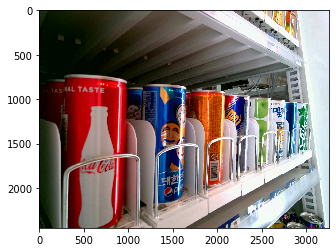

In [8]:
plt.imshow(cv2.cvtColor(img_list[2], cv2.COLOR_BGR2RGB))

In [223]:
df = pd.read_csv('./5.labels/labels_beverage_final.txt', sep = ' ', index_col=False, header=None)
#df = pd.read_csv('./5.labels/labels_sn_pd.txt', sep = ' ', index_col=False, header=None)
CLASS_NAMES = df[0].tolist()
CLASS_NAMES = sorted(CLASS_NAMES)

df = pd.read_csv('./5.labels/labels_sn_ff.txt', sep = ' ', index_col=False, header=None)
SN_FF_CLASS_NAMES = df[0].tolist()
SN_FF_CLASS_NAMES = sorted(CLASS_NAMES)

df = pd.read_csv('./5.labels/labels_sn_pd.txt', sep = ' ', index_col=False, header=None)
SN_PD_CLASS_NAMES = df[0].tolist()
SN_PD_CLASS_NAMES = sorted(CLASS_NAMES)

df = pd.read_csv('./5.labels_binary.txt', sep = ' ', index_col=False, header=None)
EM_CLASS_NAMES = df[0].tolist()
EM_CLASS_NAMES = sorted(EM_CLASS_NAMES)

empty_model = tf.keras.models.load_model('./1.model/total_empty.h5')


main_model = tf.keras.models.load_model('./1.model/walkin_beverage_final.h5')
#main_model1 = tf.keras.models.load_model('./1.model/walkin_sn_pd_final.h5')

### 시각화

In [6]:
aa = []
for i in range(1,7):
    a = glob.glob('./3.cls_imgs/{}/{}/*'.format(device, i))
    a = sorted(a, key= lambda aa : int(aa.split('/')[4].split('.')[0]))
    aa.append(a)

cc = []
for i in range(len(aa)):
    cc += aa[i]

rs = []
for i in range(len(result)):
    rs += result[i]

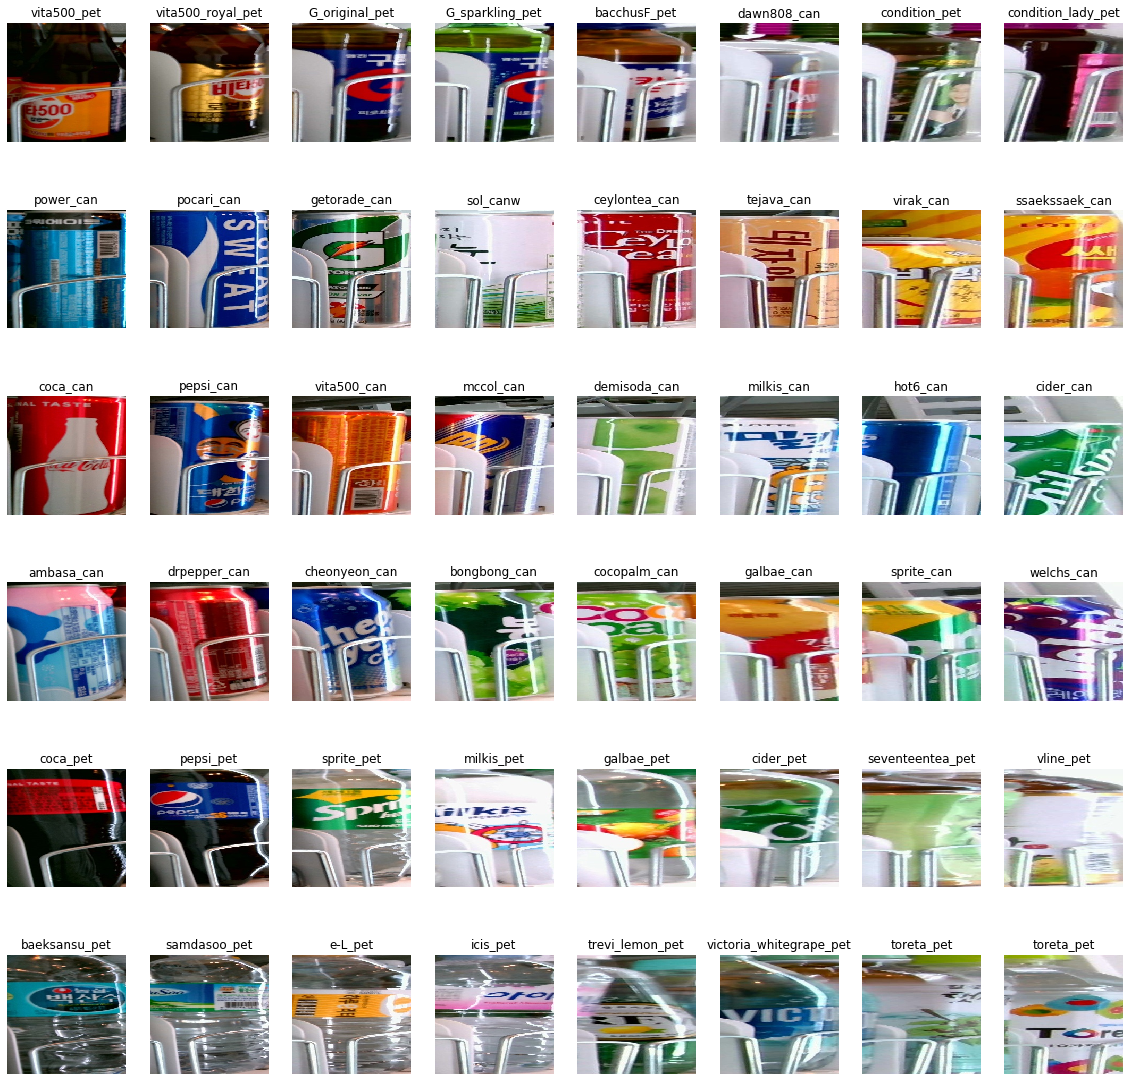

In [7]:
fig = plt.figure(2,(20,20)) # rows*cols 행렬의 i번째 subplot 생성
rows = 6
cols = 8
i = 1

for filename in cc: 
    img = cv2.imread(filename)
    ax = fig.add_subplot(rows, cols, i)
    ax.set_title('{}'.format(rs[i-1]))
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.axis("off")

    i += 1
plt.show()

---

## Test

In [ ]:
result = []
for em,pr in zip(final_empty_result, final_main_result):
    rsl = [i if i == 'empty' else j for i,j in zip(em, pr)]
    result.append(rsl)

In [359]:
test1 = []
for i in range(len(final_main_result)):
    test1 += final_main_result[i]
test2 = []
for i in range(len(final_empty_result)):
    test2 += final_empty_result[i]
